In [54]:
import numpy as np
import cv2
import pandas as pd
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [55]:
img_folder = "data/CK+48"
IMG_HEIGHT = IMG_WIDTH = 200

def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            img= cv2.imread( image_path, 0)
            img=cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
            cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
            img_data_array.append(img)
            class_name.append(dir1)
    return img_data_array, class_name
# extract the image array and class name
img_data, class_name =create_dataset(img_folder)

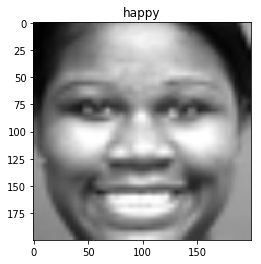

In [56]:
plt.imshow(img_data[0], cmap='gray')
plt.title(class_name[0])
plt.show()

In [57]:
def build_kernels(num_orientations, sizes):
    kernels = []
    for ang in range(num_orientations):
        th = ang /num_orientations *np.pi
        for ksize in sizes:
            ld = 1 /4.0 *np.pi
            sg = 3
            gm = 0.75
            phi = 0
            kern = cv2.getGaborKernel((ksize, ksize), sg, th, ld, gm, phi)
            kern /= 1.5*kern.sum()
            kernels.append(kern)
    return kernels

In [58]:
def process_img(img, kernels):
    accum = np.zeros_like(img)
    for kernel in kernels:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
        np.maximum(accum, fimg, accum)
    return accum

In [59]:
def extract_features(img, f):
    H,W = img.shape
    feat = []
    #calculating the local energy for each convolved image
    for j in range(len(f)):
        res = process_img(img, f[j])
        temp = 0
        for p in range(H):
            for q in range(W):
                temp = temp + float(res[p][q])**2
        feat.append(temp)
    #calculating the mean amplitude for each convolved image	
    for j in range(len(f)):
        res = process_img(img, f[j])
        temp = 0
        for p in range(H):
            for q in range(W):
                temp = temp + abs(res[p][q])
        feat.append(temp)
    return feat

In [60]:
#instantiating the filters
print("build kernels")
filters = build_kernels(12,[7,9,11,13,15,17,19])
f = np.asarray(filters)
print("here")
#reading the input image
img= cv2.imread( "face2.jpeg", 0)
img=cv2.resize(img, (200, 200))
cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
print("extract")
features = extract_features(img, f)

build kernels
here
extract


In [61]:
print(len(features))

168


In [62]:
%%time
feature_vectors = []
for image in img_data:
    feature_vectors.append(extract_features(image, f))

CPU times: user 1h 13min 5s, sys: 1min 10s, total: 1h 14min 16s
Wall time: 1h 17min 17s


In [63]:
print(len(feature_vectors))

981


In [64]:
feature_dataset = np.array([np.array(xi) for xi in feature_vectors])
print(feature_dataset.shape)

(981, 168)


In [65]:
fdf = pd.DataFrame()
fdf["Labels"] = class_name
fdf = fdf.join(pd.DataFrame(feature_dataset))
fdf.head()

,Labels,0,1,2,3,4,5,6,7,8,...,158,159,160,161,162,163,164,165,166,167
0,happy,10123055.0,6986881.0,5904221.0,4781874.0,101745578.0,5852733.0,188429378.0,1.067924e+09,466259648.0,...,9669182.0,9706447.0,9988183.0,5981339.0,3841970.0,4448971.0,10122556.0,10167762.0,9733089.0,10135151.0
1,happy,11450940.0,7946990.0,6658455.0,5434640.0,98374110.0,6383013.0,183015362.0,1.164857e+09,482131283.0,...,9232154.0,9305816.0,9659483.0,5959815.0,3800573.0,4476898.0,9858633.0,9931189.0,9319000.0,9879358.0
2,happy,17167028.0,12115993.0,9894743.0,8294814.0,111905952.0,9221396.0,195681859.0,1.650794e+09,581739488.0,...,9675610.0,9738423.0,10079663.0,7380397.0,4305452.0,5612920.0,10155117.0,10179046.0,9724605.0,10145471.0
3,happy,5266012.0,3609899.0,3078330.0,2456836.0,64265484.0,3076850.0,135061057.0,5.590896e+08,296551301.0,...,9500277.0,9601231.0,10087345.0,4105460.0,2962885.0,3111001.0,10157757.0,10182408.0,9502746.0,10107989.0
4,happy,16290109.0,11383488.0,9544144.0,7814229.0,138348918.0,9582897.0,226899041.0,1.598670e+09,645583701.0,...,9875218.0,9910279.0,10126130.0,7447360.0,4573967.0,5681498.0,10176554.0,10189077.0,9917062.0,10169500.0


In [66]:
fdf.to_csv('features.csv', index=False)